In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Set the random seed
torch.manual_seed(0)

'''
assume that datasets are given, after preprocessing
'''
# Set the random seed
torch.manual_seed(0)

# Create a random dataset
dataset_size = 1200
data = torch.randn(dataset_size, 22, 128, 8)

labels = torch.randint(2, (dataset_size,))
train_dataset = list(zip(data[:500], torch.zeros(500, dtype=torch.int)))
train_dataset += list(zip(data[500:1000], torch.ones(500, dtype=torch.int)))

test_dataset = list(zip(data[1000:1100], torch.zeros(200, dtype=torch.int)))
test_dataset += list(zip(data[1100:], torch.ones(200, dtype=torch.int)))

In [7]:
# Set the random seed
from tqdm.notebook import tqdm
torch.manual_seed(0)

class SciCNN(nn.Module):

    def __init__(self):
        super(SciCNN, self).__init__()        

        self.inception1 = Inception(8, 8, 16, 8, 8)
        self.maxpool1 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception2 = Inception(16, 16, 8, 16, 4)
        self.maxpool2 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception3 = Inception(32, 32, 4, 32, 2)
        self.maxpool3 = nn.MaxPool2d((1, 8), stride=(1, 8), ceil_mode=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(22*64, 16)
        self.npc = NPC()
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.inception1(x)
        x = self.maxpool1(x)
        x = self.inception2(x)
        x = self.maxpool2(x)
        x = self.inception3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Inception(nn.Module):

    def __init__(self, in_channels, ch1, ch1_kernel, ch2, ch2_kernel):
        super(Inception, self).__init__()
        self.branch1 = BasicConv1d(in_channels, ch1, kernel=(1, ch1_kernel), padding=(0, (ch1_kernel-1)//2))
        
        self.branch2 = BasicConv1d(in_channels, ch2, kernel=(1, ch2_kernel), padding=(0, (ch2_kernel-1)//2))

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], dim=1)

class BasicConv1d(nn.Module): 
    def __init__(self, in_channels, out_channels, kernel, padding):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)
    
class NPC(nn.Module):
    def __init__(self, num_clusters=256):
        super(NPC, self).__init__()
        # 256 predefined positions of NPC clusters
        self.position = nn.Parameter(torch.randn(num_clusters, 16, 1))
        self.label = nn.Parameter(torch.randint(1, (num_clusters,)), requires_grad=False)

model = SciCNN().to(device)

def npc_loss(output, label, model):
    # output: (batch    _size, 16, 1)
    mean_output = torch.mean(output, dim=0)
    distances = torch.norm(mean_output - model.npc.position)
    closest_position_index = torch.argmin(distances)
    closest_position = model.npc.position[closest_position_index]
    model.npc.label[closest_position_index] = torch.max(label)
    loss = torch.norm(mean_output - closest_position)
    return loss
    

model = SciCNN().to(device)
loss_function = npc_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=5e-4)

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=False)

train_loss_list = []

import time
start = time.time()
for epoch in tqdm(range(100)):
    loss=0
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels, model)
        loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(loss/len(train_loader))
    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, loss/len(train_loader)))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels, model).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1] Loss: 82.3906
Epoch [2] Loss: 20.4333
Epoch [3] Loss: 13.3918
Epoch [4] Loss: 9.8690
Epoch [5] Loss: 7.0906
Epoch [6] Loss: 4.7321
Epoch [7] Loss: 3.0323
Epoch [8] Loss: 1.7992
Epoch [9] Loss: 1.1457
Epoch [10] Loss: 0.8285
Epoch [11] Loss: 0.6628
Epoch [12] Loss: 0.5717
Epoch [13] Loss: 0.5752
Epoch [14] Loss: 0.4753
Epoch [15] Loss: 0.4072
Epoch [16] Loss: 0.3757
Epoch [17] Loss: 0.3317
Epoch [18] Loss: 0.3096
Epoch [19] Loss: 0.2906
Epoch [20] Loss: 0.2464
Epoch [21] Loss: 0.2552
Epoch [22] Loss: 0.2211
Epoch [23] Loss: 0.1983
Epoch [24] Loss: 0.2227
Epoch [25] Loss: 0.2073
Epoch [26] Loss: 0.1958
Epoch [27] Loss: 0.1721
Epoch [28] Loss: 0.1896
Epoch [29] Loss: 0.1875
Epoch [30] Loss: 0.1631
Epoch [31] Loss: 0.1551
Epoch [32] Loss: 0.1498
Epoch [33] Loss: 0.1367
Epoch [34] Loss: 0.1486
Epoch [35] Loss: 0.1984
Epoch [36] Loss: 0.1843
Epoch [37] Loss: 0.1768
Epoch [38] Loss: 0.1689
Epoch [39] Loss: 0.1631
Epoch [40] Loss: 0.1570
Epoch [41] Loss: 0.1549
Epoch [42] Loss: 0.151

/Users/daeheonkwon/anaconda3/envs/EEG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/daeheonkwon/anaconda3/envs/EEG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Training Loss')

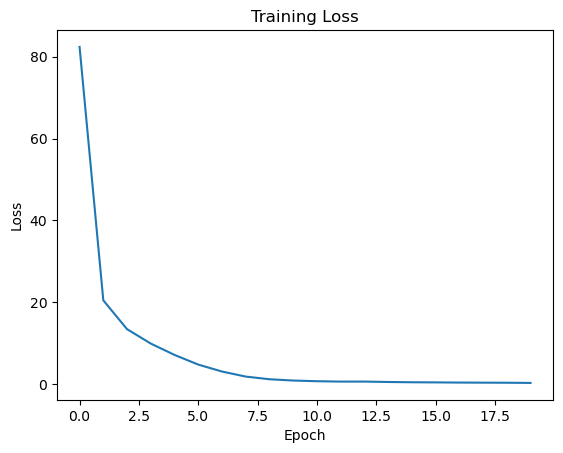

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
loss_plot = train_loss_list[:20]
sns.lineplot(x=range(len(loss_plot)), y=loss_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


In [63]:
loss

NameError: name 'loss' is not defined